**Automated Parameter Selection**: Auto-ARIMA, on the other hand, automates the process of selecting the order of the ARIMA model.
- Search Algorithm: Auto-ARIMA typically employs a search algorithm that explores different combinations of AR, I, and MA orders to find the model with the lowest Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
- Ease of Use: Auto-ARIMA is user-friendly and requires less manual intervention compared to traditional ARIMA. It is suitable for users who are less familiar with time series analysis.

# Preprocessing

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pmdarima.arima import auto_arima

In [3]:
# import data
df = pd.read_csv('df_post_eda.csv')

In [4]:
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)
df.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [5]:
# Scale data -> some % columns, some raw number columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,0.000000
2021-11-10,0.070026
2021-11-17,0.135949
2021-11-24,0.204748
2021-12-01,0.254180


In [6]:
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[0:train_size], df_scaled[train_size:]
print(train.shape, test.shape)

(61, 1) (19, 1)


# Model Building

#### No Tuning of Auto-ARIMA

In [7]:
model = auto_arima(train, seasonal=True, m=12, 
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      seasonal_order=None,   # Let the algorithm determine the optimal seasonal order
                   seasonal_test='ocsb', # Use 'ocsb' for seasonal order selection
                        random_state=45)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=-416.820, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.38 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.11 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.09 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.35 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.17 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 0, 2, 1
P, D, Q, S = 1, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
# overfitting

Optimization terminated successfully.
         Current function value: -3.531121
         Iterations: 2
         Function evaluations: 122
Training RMSE: 0.010981423610464548
Testing RMSE: 0.005517790178342288


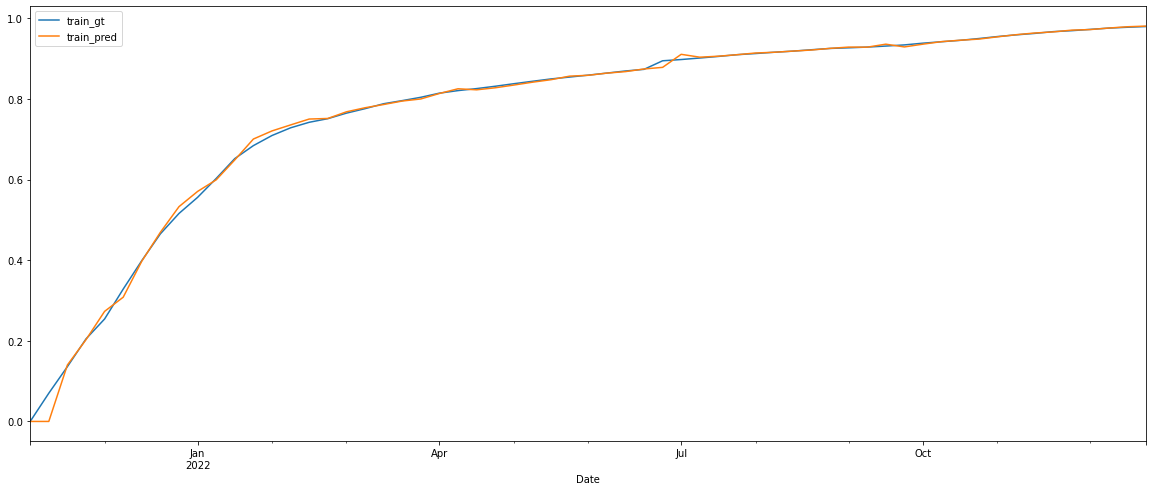

In [9]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

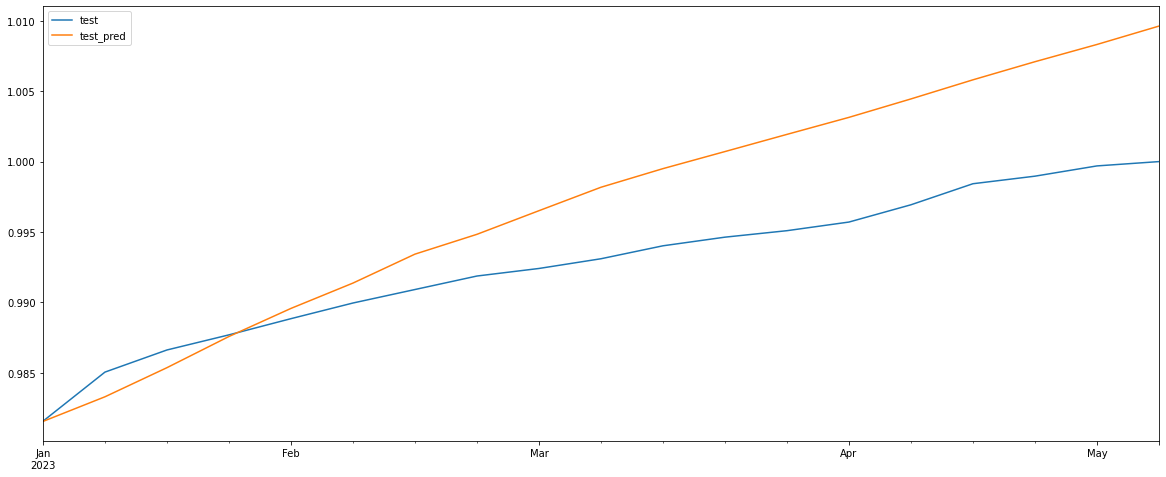

In [10]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

## Tuning

In [19]:
model = auto_arima(train, seasonal=True, m=12,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=3, max_q=3, 
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_order=None,  # Let the algorithm determine the optimal seasonal order
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-417.994, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.50 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.13 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.10 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.46 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.17 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.07 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.21 sec
 ARIMA(1,2,0)(1,0,0

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Best hyperparameters
p, d, q = 0, 2, 1
P, D, Q, S = 1, 0, 0, 12

# Create and train the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S))
fit_model = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

# Make predictions on the training set (fitted values)
train_pred = fit_model.fittedvalues

# Make predictions on the test set
test_pred = fit_model.get_forecast(steps=len(test))
test_pred_mean = test_pred.predicted_mean

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for test set
test_rmse = sqrt(mean_squared_error(test, test_pred_mean))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Optimization terminated successfully.
         Current function value: -3.531121
         Iterations: 2
         Function evaluations: 122
Training RMSE: 0.010981423610464548
Testing RMSE: 0.005517790178342288


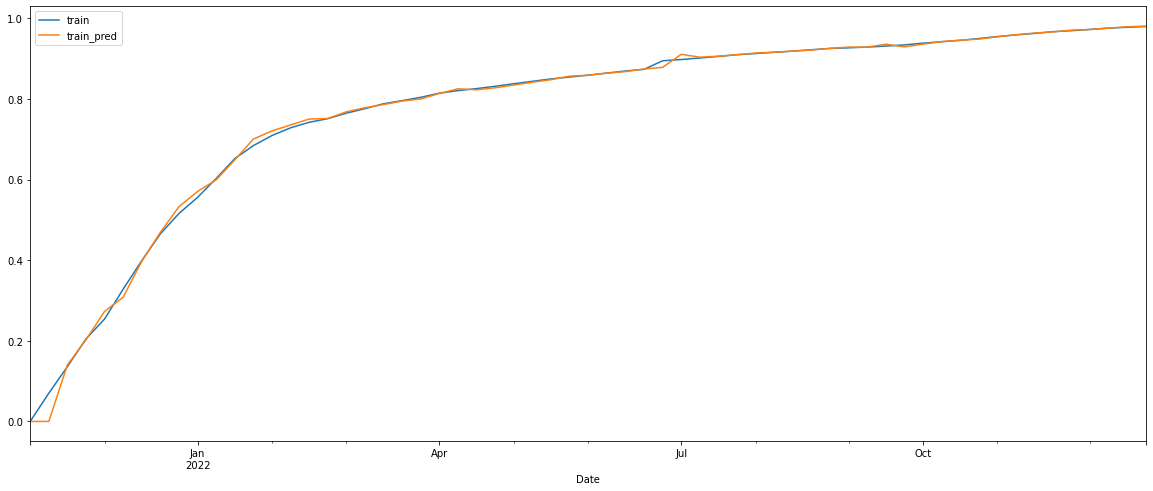

In [21]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

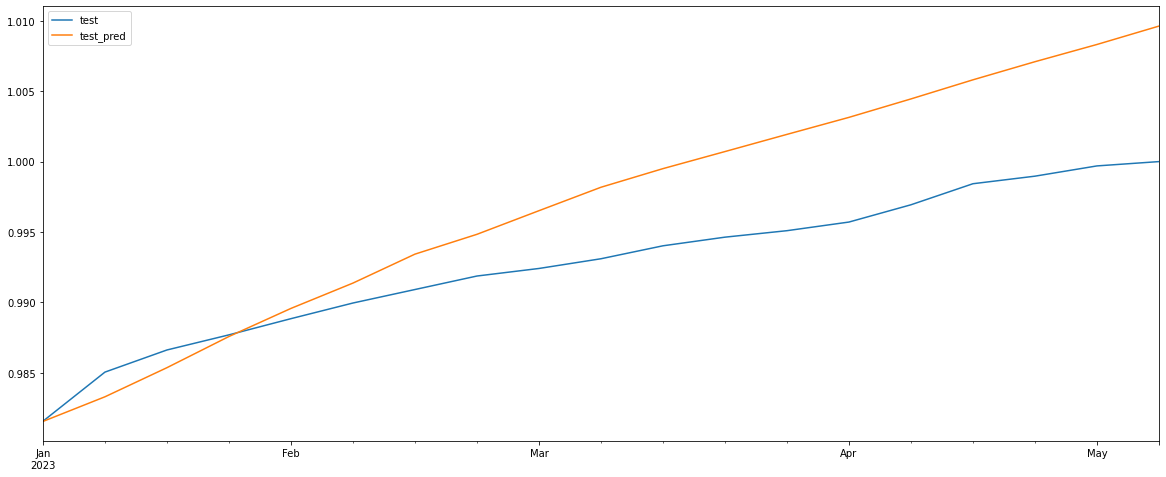

In [22]:
pd.concat([test, test_pred_mean], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

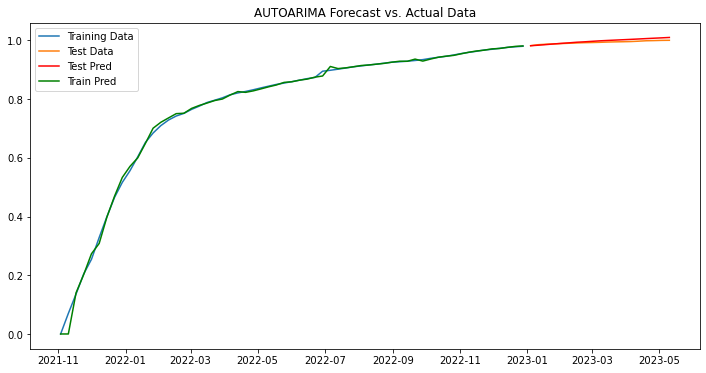

In [23]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred_mean, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

# Larger Grid Search

In [24]:
model = auto_arima(train, seasonal=True, m=12,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=5, max_q=5, 
                      start_P=0, start_Q=0, max_P=5, max_Q=5,
                      D=None, # want algorithm to determin optimal value for D
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.47 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.12 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.13 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.47 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.09 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.17 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.19 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-425.204, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0

In [ ]:
# larger range for p, q, P and Q values -> returned same result

In [25]:
# a little larger
model = auto_arima(train, seasonal=True, m=12,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=10, max_q=10, 
                      start_P=0, start_Q=0, max_P=10, max_Q=10,
                      D=None, # want algorithm to determin optimal value for D
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-422.034, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-424.844, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-424.468, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-423.808, Time=0.04 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-422.859, Time=0.44 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-422.812, Time=0.15 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-424.527, Time=0.13 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-420.904, Time=0.38 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-423.070, Time=0.08 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=-422.906, Time=0.17 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=-422.056, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=-424.006, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=-420.921, Time=0.18 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=-425.204, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0

In [29]:
# seems that our data is setting d=2 and D=0

## Changing m

In [30]:
# Define a range of m values to iterate over
m_values = [1, 4, 7, 12, 24]  # Adjust this list based on your considerations

best_rmse = float('inf')
best_m = None

for m in m_values:
    model = auto_arima(train, seasonal=True, m=m,  
                      suppress_warnings=True, stepwise=True,
                      error_action='warn', trace=True,
                      random_state = 45,
                      start_p=0, start_q=0, max_p=3, max_q=3, 
                      start_P=0, start_Q=0, max_P=3, max_Q=3,
                      D=None, # want algorithm to determin optimal value for D
                      d=None, # want algorithm to determin optimal value for d
                      seasonal_test='ocsb',  # Use 'ocsb' for seasonal order selection
                      suppress_state_transition_warnings=True)
    
    # Make predictions on the test set
    test_predictions = model.predict(len(test))
    
    # Calculate RMSE for the current m value
    rmse = sqrt(mean_squared_error(test, test_predictions))
    
    # Update the best m if the current m performs better
    if rmse < best_rmse:
        best_rmse = rmse
        best_m = m

print('Best Model Test RMSE:', best_rmse)
print('Best Model m:', best_m)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-422.034, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-423.808, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-423.754, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-421.822, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-421.799, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-419.835, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-424.874, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-421.845, Time=0.03 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-423.152, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-423.335, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-425.399, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-423.399, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-413.370, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.550 seconds
Performing stepwise se

 ARIMA(0,2,1)(0,0,1)[24] intercept   : AIC=-423.399, Time=0.42 sec
 ARIMA(0,2,1)(1,0,1)[24] intercept   : AIC=-421.397, Time=0.63 sec
 ARIMA(0,2,2)(0,0,0)[24] intercept   : AIC=-423.399, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[24] intercept   : AIC=-413.370, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[24] intercept
Total fit time: 5.331 seconds
Best Model Test RMSE: 0.0845601255764781
Best Model m: 12


In [31]:
# best model still returned m=12
#  ARIMA(0,2,1)(1,0,0)[12]
# same best ARIMA model as above!

### TimeSeriesSplit

In [12]:
tscv = TimeSeriesSplit(n_splits=5, test_size=4, gap=3)

# Initialize variables to store the best model parameters and lowest RMSE
best_order = None
best_rmse = float('inf')

# Iterate through the time series splits
for train_index, test_index in tscv.split(train):
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]

    # Use auto_arima to find the best order parameters
    model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True, 
                           d=2, D =0, trace=True,
                        error_action='ignore', suppress_warnings=True, stepwise=False)
    order = model.get_params()['order']
    seasonal_order = model.get_params()['seasonal_order']

    # Train SARIMAX model with the best order parameters
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    arima_fit = model.fit(enforce_stationarity=False, enforce_invertibility=False, method='powell')

    # Make predictions on the test set
    predictions = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

    # Calculate RMSE for the test set
    rmse = np.sqrt(mean_squared_error(test_data, predictions))

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_order = order
        best_seasonal_order = seasonal_order

# Print the best order parameters and the corresponding RMSE
print(f"Best Order Parameters: {best_order}")
print(f"Best Seasonal Order Parameters: {best_seasonal_order}")
print(f"Lowest Test RMSE: {best_rmse}")

 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-62.951, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-60.951, Time=0.04 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-58.951, Time=0.31 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-56.951, Time=1.75 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-54.951, Time=4.99 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=-52.951, Time=1.42 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-60.951, Time=0.06 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-58.951, Time=0.08 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=-56.951, Time=0.38 sec
 ARIMA(0,2,0)(1,0,3)[12]             : AIC=-54.951, Time=2.15 sec
 ARIMA(0,2,0)(1,0,4)[12]             : AIC=-52.951, Time=2.66 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=-58.951, Time=0.39 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=-56.951, Time=0.58 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=-54.951, Time=0.50 sec
 ARIMA(0,2,0)(2,0,3)[12]             : AIC=-52.951, Time=2.34 sec
 ARIMA(0,2

 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-154.970, Time=0.09 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-152.970, Time=0.63 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-150.970, Time=5.34 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-148.970, Time=6.15 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=-146.969, Time=12.51 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-154.970, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-152.970, Time=0.12 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=-150.970, Time=0.46 sec
 ARIMA(0,2,0)(1,0,3)[12]             : AIC=-148.970, Time=6.82 sec
 ARIMA(0,2,0)(1,0,4)[12]             : AIC=-146.969, Time=4.87 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=-152.966, Time=0.59 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=-150.970, Time=0.47 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=-148.970, Time=0.54 sec
 ARIMA(0,2,0)(2,0,3)[12]             : AIC=-146.970, Time=8.06 sec
 ARIMA(0,2,0)(3,0,0)[12]             : AIC=-150.970, Time=3.7

 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-247.275, Time=0.15 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=-245.483, Time=0.88 sec
 ARIMA(0,2,0)(0,0,3)[12]             : AIC=-243.486, Time=8.38 sec
 ARIMA(0,2,0)(0,0,4)[12]             : AIC=-241.485, Time=14.70 sec
 ARIMA(0,2,0)(0,0,5)[12]             : AIC=-239.485, Time=18.30 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-246.773, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-245.029, Time=0.15 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=-243.487, Time=1.14 sec
 ARIMA(0,2,0)(1,0,3)[12]             : AIC=-241.487, Time=5.78 sec
 ARIMA(0,2,0)(1,0,4)[12]             : AIC=-239.487, Time=9.90 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=-245.449, Time=0.54 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=-243.486, Time=0.62 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=-241.476, Time=0.99 sec
 ARIMA(0,2,0)(2,0,3)[12]             : AIC=-239.485, Time=9.56 sec
 ARIMA(0,2,0)(3,0,0)[12]             : AIC=-243.485, Time=9.

KeyboardInterrupt: 